# Statistical Parameter Estimation 2024
## Exercise 2

Author: Alex Karonen

Let us consider a simple exponential decay
$$ \begin{split}
    y(t) &= \theta_1 + (A_0 - \theta_1) \exp(-\theta_2t) + \epsilon(t), \\
    y(t) &= f(t;\theta) + \epsilon(t), ~\text{where} ~\theta = (\theta_1, \theta_2)^T;
    \end{split}
$$

Let the data be
$$\begin{split} 
    y(t) &= (0.487, 0.572, 0.369, 0.179, 0.119, 0.0809, 0.104, 0.091, 0.047, 0.051)^T, \\
      t  &= (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)^T\\
  \epsilon(t) &= N(0,\sigma^2I).
  \end{split}
$$


1. Assume first that $A_0$ = 1.
- Write the likelihood density of $\theta$ given $y(t)$
- Derive the negative log-likelihood.

The likelihood density can be formulated as follows:
$$
p(y(t)|\theta) = L(\theta) = \frac{1}{\sqrt{(2\pi)|\sigma^2\textbf{I}|}}\text{exp}(-\frac{1}{2}\frac{\sum^{11}_{i=1}(y(t_i)-f(t_i;\theta))^2}{\sigma^2})
$$

Furthermore the negative log-likelihood goes as follows:

$$
\begin{split}
    -\text{log}(L(\theta))&= -\text{log}(\frac{1}{\sqrt{(2\pi)|\sigma^2\textbf{I}|}}\text{exp}(-\frac{1}{2}\frac{\sum^{11}_{i=1}(y(t_i)-f(t_i;\theta))^2}{\sigma^2}))\\
    &= -\text{log}(\frac{1}{\sqrt{(2\pi)|\sigma^2\textbf{I}|}})-\text{log}(\text{exp}(-\frac{1}{2}\frac{\sum^{10}_{i=1}(y(t_i)-f(t_i;\theta))^2}{\sigma^2})) \\
    &= \text{log}(\sqrt{(2\pi)|\sigma^2\textbf{I}|}) + \frac{1}{2}\frac{\sum^{10}_{i=1}(y(t_i)-f(t_i;\theta))^2}{\sigma^2}\\
    &= \frac{1}{2}\text{log}(2\pi)+\text{log}(\sigma) + \frac{1}{2\sigma^2} \sum^{10}_{i=1}(y(t_i)-f(t_i;\theta))^2
\end{split}
$$

In [45]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
import warnings

warnings.filterwarnings("ignore")

t = np.arange(1, 11)
y_t = np.array([0.487, 0.572, 0.369, 0.179, 0.119, 0.0809, 0.104, 0.091, 0.047, 0.051])

# A0 = 1
# f = lambda theta: theta[0] + (A0 - theta[0]) * np.exp(-theta[1] * t) # Use this is A0 is fixed
f = lambda theta: theta[0] + (theta[2] - theta[0]) * np.exp(-theta[1] * t)

sigma = 0.1

neg_log_likelihood = lambda theta: (
    1 / 2 * np.log(2 * np.pi)
    + np.log(sigma)
    + 1 / (2 * sigma**2) * np.sum((y_t - f(theta)) ** 2)
)

2. MLE

In [46]:
x0 = np.zeros(shape=(3,))
#x0 = np.zeros(shape=(2,)) # Use this is A0 is fixed
optim = scipy.optimize.fmin(neg_log_likelihood, x0=x0)

print(
    f"Found maximum likelihood estimators: theta_1 = {optim[0]}, theta_2 = {optim[1]}"
)

Found maximum likelihood estimators: theta_1 = 6.357083199549914, theta_2 = -0.009041289103875923


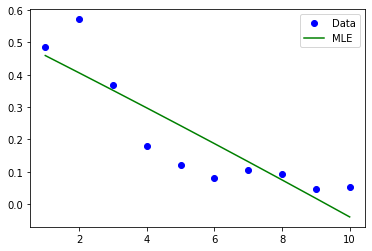

In [47]:
plt.plot(t,y_t, 'bo', t, f(optim), 'g')
plt.legend(["Data", "MLE"])
plt.show()

3. CM estimators:
- Metropolis-Hastings

In [48]:
def MHMC(lh, dist, init_state, N):
    burnin = int(0.2 * N)
    curr_state = init_state
    curr_lh = lh(curr_state)

    samples = []
    R = np.linalg.cholesky(np.eye(len(init_state)))
    for _ in range(N):
        proposal_state = dist(curr_state, R)
        prop_lh = lh(proposal_state)

        acc_crit = prop_lh / curr_lh

        acc_threshold = np.random.uniform(0, 1)

        if acc_crit > acc_threshold:
            curr_state = proposal_state
            curr_lh = prop_lh

        samples.append(curr_state)

    return np.array(samples[burnin:])


N = int(2e4)

dist = lambda sample, R: sample + np.random.normal(size=sample.shape) @ R

likelihood = lambda theta: np.exp(-1 / 2 * np.sum((y_t - f(theta)) ** 2) / sigma**2)

MH_samples = MHMC(likelihood, dist, x0, N)

- Adaptive Metropolis

In [49]:
def adap_MHMC(lh, dist, init_state, init_Cov, N, N0):
    burnin = int(0.2 * N)
    curr_state = init_state
    curr_Cov = init_Cov
    curr_lh = lh(curr_state)
    eps = 1e-9
    sd = (2.4**2) / len(init_state)
    samples = []

    for i in range(N):
        proposal_state = dist(curr_state, np.linalg.cholesky(curr_Cov))
        prop_lh = lh(proposal_state)
        acc_crit = prop_lh / curr_lh
        acc_threshold = np.random.uniform(0, 1)

        if acc_crit > acc_threshold:
            curr_state = proposal_state
            curr_lh = prop_lh

        if i >= N0:
            delta = sd * eps * np.identity(curr_Cov.shape[0])
            curr_Cov = sd * np.cov(np.array(samples).T) + delta

        samples.append(curr_state)

    return np.array(samples[burnin:])


N0 = 1000
dist = lambda sample, R: sample + np.random.normal(size=sample.shape) @ R

aMH_samples = adap_MHMC(likelihood, dist, x0, np.eye(len(x0)), N, N0)

- Delayed rejection


In [50]:
def DRMC(lh, dist, init_state, N, m):
    burnin = int(0.2 * N)
    curr_state = init_state
    curr_lh = lh(curr_state)
    proposal_state = curr_state
    samples = []
    R = np.linalg.cholesky(np.eye(len(init_state)))
    for i in range(N):
        proposal_state = dist(curr_state, R)
        prop_lh = lh(proposal_state)
        acc_crit = prop_lh / curr_lh
        acc_threshold = np.random.uniform(0, 1)

        if acc_crit < acc_threshold:
            k = 1
            while acc_crit < acc_threshold and k <= m:
                proposal_state = dist(proposal_state, R)
                prop_lh = lh(proposal_state)
                acc_crit = prop_lh / curr_lh
                acc_threshold = np.random.uniform(0, 1)
                if acc_crit > acc_threshold:
                    curr_state = proposal_state
                    curr_lh = prop_lh
                k += 1
        else:
            curr_state = proposal_state
            curr_lh = prop_lh

        samples.append(curr_state)

    return np.array(samples[burnin:])


dist = lambda sample, R: sample + np.random.normal(size=sample.shape) @ R
DRMC_samples = DRMC(likelihood, dist, x0, N, 2)

- DRAM

In [51]:
def adap_DRMC(lh, dist, init_state, init_Cov, N, N0, m):
    burnin = int(0.2 * N)
    curr_state = init_state
    curr_Cov = init_Cov
    curr_lh = lh(curr_state)
    gamma = 1
    eps = 1e-9
    sd = (2.4**2) / len(init_state)
    samples = []

    for i in range(N):
        proposal_state = dist(curr_state, np.linalg.cholesky(curr_Cov))
        prop_lh = lh(proposal_state)
        acc_crit = prop_lh / curr_lh
        acc_threshold = np.random.uniform(0, 1)
        if acc_crit <= acc_threshold:
            k = 0
            prop_Cov = gamma * curr_Cov

            while acc_crit <= acc_threshold and k < m:
                proposal_state = dist(proposal_state, np.linalg.cholesky(prop_Cov))
                prop_lh = lh(proposal_state)
                acc_crit = prop_lh / curr_lh
                acc_threshold = np.random.uniform(0, 1)
                if acc_crit > acc_threshold:
                    curr_state = proposal_state
                    curr_lh = prop_lh
                k += 1
                prop_Cov *= gamma
        else:
            curr_state = proposal_state
            curr_lh = prop_lh
        if i >= N0:
            delta = sd * eps * np.eye(len(init_state))
            curr_Cov = sd * np.cov(np.array(samples).T) + delta
        
        
        samples.append(curr_state)

    return np.array(samples[burnin:])


N = int(1e4)
dist = lambda sample, R: sample + np.random.normal(size=sample.shape) @ R


aDRMC_samples = adap_DRMC(likelihood, dist, x0, np.eye(len(x0)), N, N0, 2)

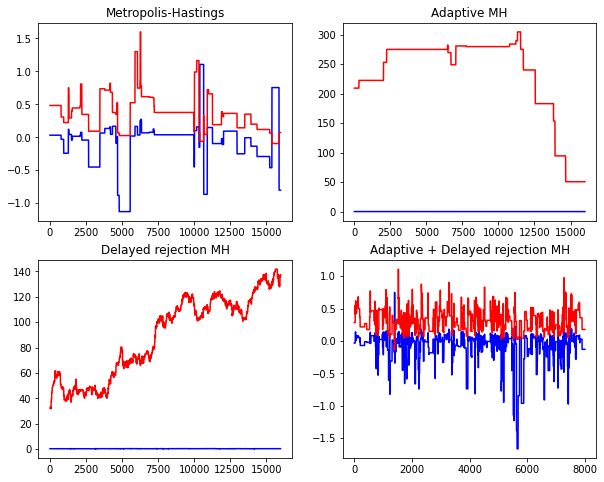

In [52]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(MH_samples[:, 0], "b", MH_samples[:, 1], "r")
plt.title("Metropolis-Hastings")

plt.subplot(222)
plt.plot(aMH_samples[:, 0], "b", aMH_samples[:, 1], "r")
plt.title("Adaptive MH")

plt.subplot(223)
plt.plot(DRMC_samples[:, 0], "b", DRMC_samples[:, 1], "r")
plt.title("Delayed rejection MH")

plt.subplot(224)
plt.plot(aDRMC_samples[:, 0], "b", aDRMC_samples[:, 1], "r")
plt.title("Adaptive + Delayed rejection MH")



plt.show()

4. Priors
- Choose a Gaussian prior for θ and define a posterior distribution.
Calculate the negative log posterior. Compute the MAP and CM
estimators as above.
- Do the same as above, but choose a prior distribution that is
uniformly distributed.

Posterior:
$$
    p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)},
$$

$$
    p(\theta) = \frac{1}{\sqrt{2\pi|\Sigma|}}exp(-\frac{1}{2}(\theta-\mu)^T\Sigma^{-11}(\theta-\mu))
$$

$$
    p(y|\theta) = \frac{1}{\sqrt{(2\pi)|\sigma^2\textbf{I}|}}\text{exp}(-\frac{1}{2}\frac{\sum^{10}_{i=1}(y(t_i)-f(t_i;\theta))^2}{\sigma^2})
$$

So the unnormalized posterior is of the form:

$$
    p(\theta|y) \propto p(\theta)p(y|\theta)
$$

Thus the negative log posterior is of the form:

$$
\begin{split}
    -L_{post}(\theta) &= -log(p(\theta|y)) \\
    &= -log(p(\theta))-log(p(y|\theta)) \\
    &= -log(p(\theta)) + \frac{1}{2}\text{log}(2\pi)+\text{log}(\sigma) + \frac{1}{2\sigma^2} \sum^{10}_{i=1}(y(t_i)-f(t_i;\theta))^2\\
    &= -log(p(\theta)) + (-L_{likeli}(\theta)) 
\end{split}
$$

MAP estimators for gaussian and uniform priors

In [53]:
neg_log_posterior_G = lambda theta: -np.log(
    np.random.normal(loc=1)
) + neg_log_likelihood(theta)

neg_log_posterior_U = lambda theta: -np.log(
    np.random.uniform(0, 1)
) + neg_log_likelihood(theta)


MAP_G = scipy.optimize.fmin(neg_log_posterior_G, x0)
MAP_U = scipy.optimize.fmin(neg_log_posterior_U, x0)

Gaussian prior for MCMCs

In [54]:
import time

prop_dist = lambda sample, R: sample +  np.random.normal(size=sample.shape) @ R

t0 = time.time()
G_MHMC = MHMC(likelihood, prop_dist, MAP_G, N)
t_G_MHMC = time.time()-t0

t0 = time.time()
G_aMHMC = adap_MHMC(likelihood, prop_dist, MAP_G, np.eye(len(MAP_G)), N, N0)
t_G_aMHMC = time.time()-t0

t0 = time.time()
G_DRMC = DRMC(likelihood, prop_dist, MAP_G, N, 2)
t_G_DRMC = time.time()-t0

t0 = time.time()
G_DRAM = adap_DRMC(likelihood, prop_dist, MAP_G, np.eye(len(MAP_G)), N, N0, 2)
t_G_DRAM = time.time()-t0

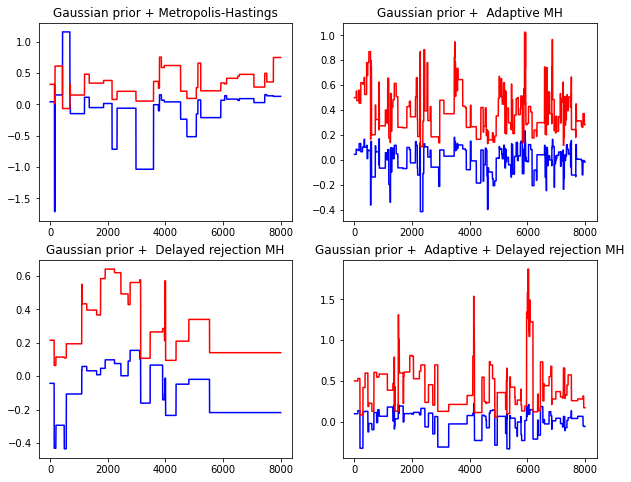

In [55]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(G_MHMC[:, 0], "b", G_MHMC[:, 1], "r")
plt.title("Gaussian prior + Metropolis-Hastings")

plt.subplot(222)
plt.plot(G_aMHMC[:, 0], "b", G_aMHMC[:, 1], "r")
plt.title("Gaussian prior +  Adaptive MH")

plt.subplot(223)
plt.plot(G_DRMC[:, 0], "b", G_DRMC[:, 1], "r")
plt.title("Gaussian prior +  Delayed rejection MH")

plt.subplot(224)
plt.plot(G_DRAM[:, 0], "b", G_DRAM[:, 1], "r")
plt.title("Gaussian prior +  Adaptive + Delayed rejection MH")


plt.show()

Uniform prior for MCMCs

In [56]:
prop_dist = lambda sample, R: np.random.uniform(0, 1, size=sample.shape)

t0 = time.time()
U_MHMC = MHMC(likelihood, prop_dist, MAP_U, N)
t_U_MHMC = time.time() - t0

t0 = time.time()
U_aMHMC = adap_MHMC(likelihood, prop_dist, MAP_U, np.eye(len(MAP_U)), N, N0)
t_U_aMHMC = time.time() - t0

t0 = time.time()
U_DRMC = DRMC(likelihood, prop_dist, MAP_U, N, 2)
t_U_DRMC = time.time() - t0

t0 = time.time()
U_DRAM = adap_DRMC(likelihood, prop_dist, MAP_U, np.eye(len(MAP_U)), N, N0, 2)
t_U_DRAM = time.time() - t0

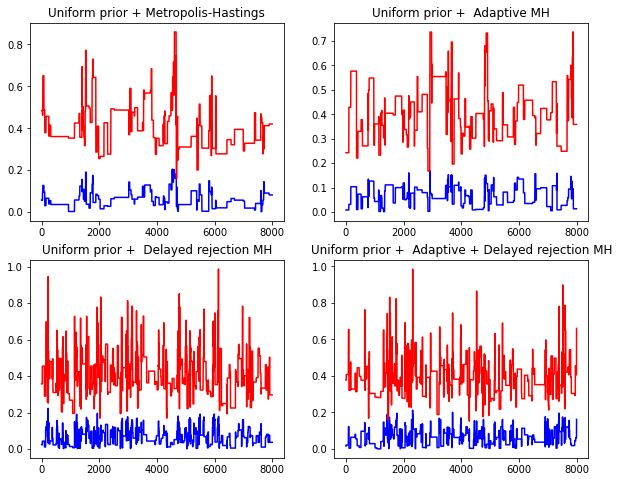

In [57]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(U_MHMC[:, 0], "b", U_MHMC[:, 1], "r")
plt.title("Uniform prior + Metropolis-Hastings")

plt.subplot(222)
plt.plot(U_aMHMC[:, 0], "b", U_aMHMC[:, 1], "r")
plt.title("Uniform prior +  Adaptive MH")

plt.subplot(223)
plt.plot(U_DRMC[:, 0], "b", U_DRMC[:, 1], "r")
plt.title("Uniform prior +  Delayed rejection MH")

plt.subplot(224)
plt.plot(U_DRAM[:, 0], "b", U_DRAM[:, 1], "r")
plt.title("Uniform prior +  Adaptive + Delayed rejection MH")


plt.show()

5. Visualisation and MCMC diagnostics


ACFs

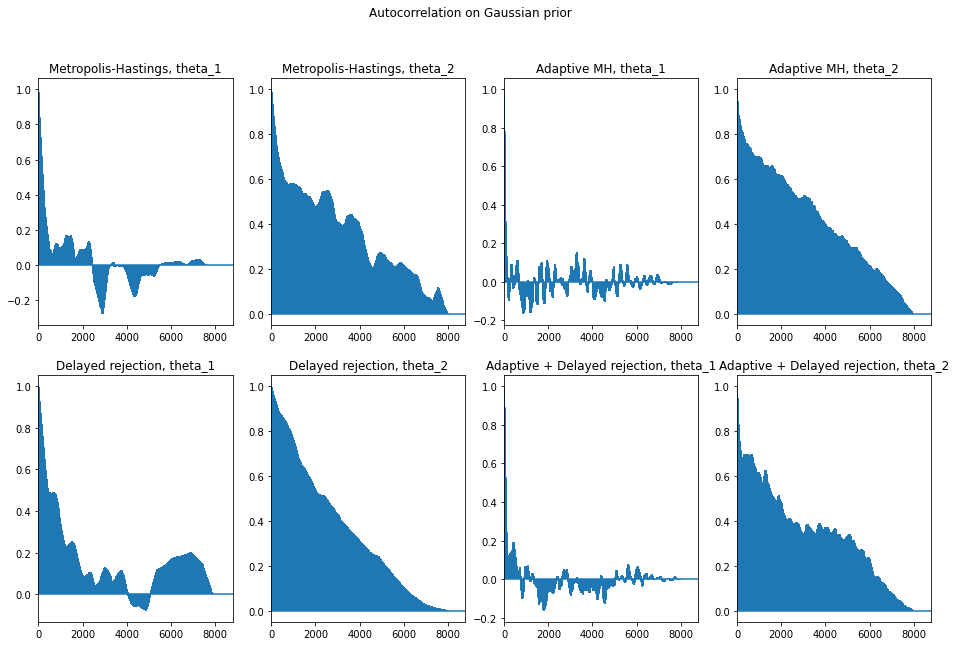

In [58]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Autocorrelation on Gaussian prior")
plt.subplot(241)
_, CG1, _, _ = plt.acorr(G_MHMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Metropolis-Hastings, theta_1")
plt.subplot(242)
_, CG2, _, _ = plt.acorr(G_MHMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Metropolis-Hastings, theta_2")


plt.subplot(243)
_, CG3, _, _ = plt.acorr(G_aMHMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive MH, theta_1")
plt.subplot(244)
_, CG4, _, _ = plt.acorr(G_aMHMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive MH, theta_2")


plt.subplot(245)
_, CG5, _, _ = plt.acorr(G_DRMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Delayed rejection, theta_1")
plt.subplot(246)
_, CG6, _, _ = plt.acorr(G_DRMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Delayed rejection, theta_2")


plt.subplot(247)
_, CG7, _, _ = plt.acorr(G_DRAM[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive + Delayed rejection, theta_1")
plt.subplot(248)
_, CG8, _, _ = plt.acorr(G_DRAM[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive + Delayed rejection, theta_2")
plt.show()

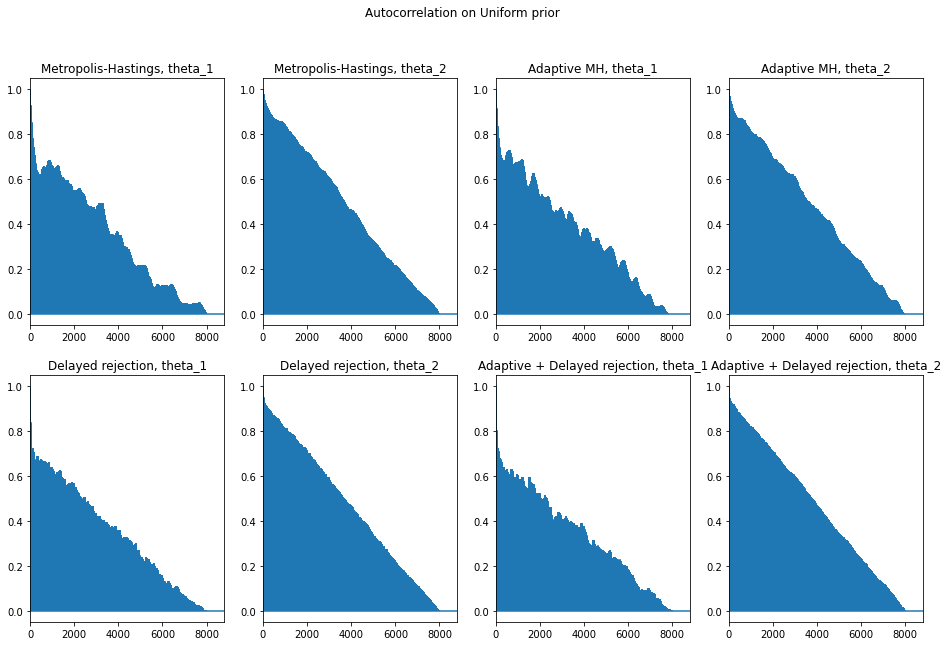

In [59]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Autocorrelation on Uniform prior")
plt.subplot(241)
_, CU1, _, _ = plt.acorr(U_MHMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Metropolis-Hastings, theta_1")
plt.subplot(242)
_, CU2, _, _ = plt.acorr(U_MHMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Metropolis-Hastings, theta_2")


plt.subplot(243)
_, CU3, _, _ = plt.acorr(U_aMHMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive MH, theta_1")
plt.subplot(244)
_, CU4, _, _ = plt.acorr(U_aMHMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive MH, theta_2")


plt.subplot(245)
_, CU5, _, _ = plt.acorr(U_DRMC[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Delayed rejection, theta_1")
plt.subplot(246)
_, CU6, _, _ = plt.acorr(U_DRMC[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Delayed rejection, theta_2")


plt.subplot(247)
_, CU7, _, _ = plt.acorr(U_DRAM[:, 0], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive + Delayed rejection, theta_1")
plt.subplot(248)
_, CU8, _, _ = plt.acorr(U_DRAM[:, 1], maxlags=None)
plt.xlim([0, None])
plt.title("Adaptive + Delayed rejection, theta_2")
plt.show()

ESS and OES

In [60]:
# Gaussian ESSs

ESS_G1 = N / (1 + 2 * np.sum(CG1[len(CG1) // 2 :]))
ESS_G2 = N / (1 + 2 * np.sum(CG2[len(CG2) // 2 :]))
ESS_G3 = N / (1 + 2 * np.sum(CG3[len(CG3) // 2 :]))
ESS_G4 = N / (1 + 2 * np.sum(CG4[len(CG4) // 2 :]))
ESS_G5 = N / (1 + 2 * np.sum(CG5[len(CG5) // 2 :]))
ESS_G6 = N / (1 + 2 * np.sum(CG6[len(CG6) // 2 :]))
ESS_G7 = N / (1 + 2 * np.sum(CG7[len(CG7) // 2 :]))
ESS_G8 = N / (1 + 2 * np.sum(CG8[len(CG8) // 2 :]))

# Uniform ESSs

ESS_U1 = N / (1 + 2 * np.sum(CU1[len(CU1) // 2 :]))
ESS_U2 = N / (1 + 2 * np.sum(CU2[len(CU2) // 2 :]))
ESS_U3 = N / (1 + 2 * np.sum(CU3[len(CU3) // 2 :]))
ESS_U4 = N / (1 + 2 * np.sum(CU4[len(CU4) // 2 :]))
ESS_U5 = N / (1 + 2 * np.sum(CU5[len(CU5) // 2 :]))
ESS_U6 = N / (1 + 2 * np.sum(CU6[len(CU6) // 2 :]))
ESS_U7 = N / (1 + 2 * np.sum(CU7[len(CU7) // 2 :]))
ESS_U8 = N / (1 + 2 * np.sum(CU8[len(CU8) // 2 :]))


# Gaussian OESs


OES_G1 = ESS_G1 / t_G_MHMC
OES_G2 = ESS_G2 / t_G_aMHMC
OES_G3 = ESS_G3 / t_G_DRMC
OES_G4 = ESS_G4 / t_G_DRAM
OES_G5 = ESS_G5 / t_G_MHMC
OES_G6 = ESS_G6 / t_G_aMHMC
OES_G7 = ESS_G7 / t_G_DRMC
OES_G8 = ESS_G8 / t_G_DRAM


# Uniform ESSs

OES_U1 = ESS_U1 / t_G_MHMC
OES_U2 = ESS_U2 / t_G_aMHMC
OES_U3 = ESS_U3 / t_G_DRMC
OES_U4 = ESS_U4 / t_G_DRAM
OES_U5 = ESS_U5 / t_G_MHMC
OES_U6 = ESS_U6 / t_G_aMHMC
OES_U7 = ESS_U7 / t_G_DRMC
OES_U8 = ESS_U8 / t_G_DRAM

- Consider different strategies to handle uncertainty in observation,
$\sigma$.

One method could be to add it as an parameter to the sampler. Also the chains could be run multiple times with different starting points and different values for $\sigma$ to find the optimal model. By studying the diagnostics of different models, it is possible to determine somewhat optimal value for $\sigma$.

- How would you handle the fact that observations are constrained to
positive?

By using suitable priors for the parameters, we can try to fix the model values to the positive. This means that we can induce some constraints on the parameter values (for example $\theta_2>0$ and if $A_0>\theta_1 \rightarrow \theta_1>(A_0-\theta_1)\exp(...)$) by choosing the priors well.

- Add A0 as an extra parameter.

The code is done with $A_0$ as an parameter. If $A_0$ is fixed, uncomment the parts where I've mentioned "if $A_0$ fixed".